In [55]:
import sys
sys.path.append('..')

import warnings
warnings.filterwarnings("ignore")

import os
import torch
import pickle
import numpy as np
import pandas as pd
from copy import deepcopy
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from matplotlib.colors import TABLEAU_COLORS

from uncertain.utils.data import Data
from uncertain.utils.training import train
from uncertain.utils.evaluation import test

from uncertain.explicit import Bias, MF, CPMF, OrdRec, BeMF
from uncertain.extras import Ensemble, Resample, UncertainWrapper, UserHeuristic, ItemHeuristic

data = pd.read_csv('data.csv')
data.columns = ['user', 'item', 'score', 'timestamps']
data = Data(data, implicit=False)

os.chdir('Movielens')

FileNotFoundError: [Errno 2] No such file or directory: 'data.csv'

# ExplicitMF (FunkSVD)

In [3]:
for wd in [5, 2, 1, 0.1, 0.001, 0.0001]:
    model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0.0002, weight_decay=wd)
    train(model, data, path='checkpoints/baseline', name=f'wd={wd}')

files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/baseline')}
model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/baseline', min(files, key=files.get)))
test(model, data, name='Baseline', max_k=10)

  0%|          | 0/6040 [00:00<?, ?it/s]

{'ratings': {'RMSE': 0.8876883831149761},
 'accuracy': {'Precision': array([0.09850993, 0.09163907, 0.08559603, 0.08290563, 0.07963576,
         0.07809051, 0.07526017, 0.07369619, 0.07170714, 0.07029801]),
  'Recall': array([0.006714  , 0.01252474, 0.01711019, 0.02176112, 0.02599113,
         0.03057623, 0.03435939, 0.03820506, 0.04139517, 0.04526395]),
  'NDCG': array([0.09850993, 0.19760495, 0.27921164, 0.34710639, 0.40372202,
         0.45045307, 0.49266869, 0.53038998, 0.56400138, 0.5966296 ]),
  'Diversity': array([0.2939656 , 0.30138914, 0.30687328, 0.31141732, 0.31519651,
         0.31886888, 0.32158252, 0.32445627, 0.32699436]),
  'Expected surprise': array([0.02910329, 0.04329912, 0.0528528 , 0.06016167, 0.06592897,
         0.07054956, 0.07428067, 0.07813579, 0.08128847, 0.08442513])}}

# Heuristics

  0%|          | 0/6040 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

{'ratings': {'avg_unc': 0.9838891288696586,
  'std_unc': 0.24788583847613962,
  'RPI': 0.39087870341842385,
  'Classification': 0.5720005098421597,
  'Quantile RMSE': array([0.80133022, 0.77600897, 0.78206156, 0.81348985, 0.8169565 ,
         0.85244326, 0.84498785, 0.84669993, 0.85678213, 0.87639551,
         0.87415901, 0.8938542 , 0.88671967, 0.90394328, 0.91126401,
         0.93397309, 0.95903945, 0.96582444, 1.01400055, 1.0771896 ])},
 'uncertainty': {'Uncertainty_TopK': array([0.73564642, 0.7240326 , 0.72398793, 0.7286079 , 0.72346941,
         0.72206369, 0.72471032, 0.72729539, 0.72768736, 0.72845259,
         0.72756411, 0.72562527, 0.72635948, 0.72632725, 0.72984143,
         0.73106783, 0.7313623 , 0.7326767 , 0.73733826, 0.73604004,
         0.73839242, 0.73537454, 0.73838698, 0.73805015, 0.74112782,
         0.7413605 , 0.73904124, 0.74034996, 0.74269641, 0.74704975,
         0.74093914, 0.74421275, 0.74999349, 0.74683397, 0.75067929,
         0.74897834, 0.7493508 , 0.747

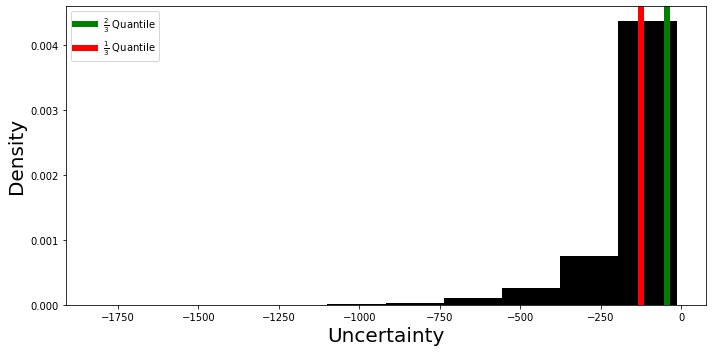

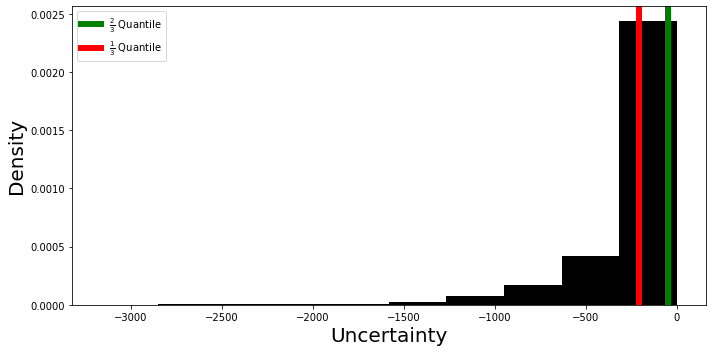

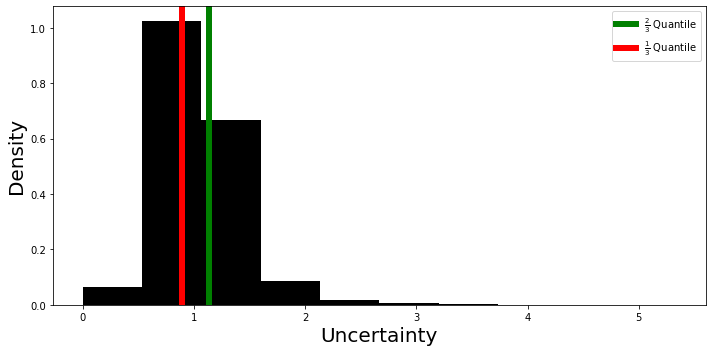

In [5]:
# user_support = np.bincount(data.train_val.user)
item = data.train_val.groupby('item').agg({'user': 'size', 'score': 'var'})
empty = np.where(~pd.Series(np.arange(data.n_item)).isin(item.index))[0]
empty = pd.DataFrame(np.full((len(empty), 2), float('NaN')), index=empty, columns=['user', 'score'])
item = item.append(empty).sort_index().fillna(0).to_numpy()
# test(UserHeuristic(base_MF=model, uncertainty=-user_support), data, name='User_support', max_k=10, use_baseline=True)
test(ItemHeuristic(base_MF=model, uncertainty=-item[:, 0]), data, name='Item_support', max_k=10, use_baseline=True)
test(ItemHeuristic(base_MF=model, uncertainty=item[:, 1]), data, name='Item_variance', max_k=10, use_baseline=True)

# Ensemble

  0%|          | 0/6040 [00:00<?, ?it/s]

{'ratings': {'RMSE': 0.8810036720887441,
  'avg_unc': 0.09568527556838195,
  'std_unc': 0.0654225951126956,
  'RPI': 0.33351074498812344,
  'Classification': 0.5414977537385115,
  'Quantile RMSE': array([0.83575909, 0.8307459 , 0.83796188, 0.84109641, 0.84240778,
         0.84312556, 0.84282235, 0.84187775, 0.84183675, 0.86373876,
         0.86125495, 0.87151424, 0.86699875, 0.87678214, 0.90264803,
         0.92312048, 0.92566935, 0.93250179, 0.96977506, 1.03632101])},
 'accuracy': {'Precision': array([0.10231788, 0.09205298, 0.08863135, 0.08460265, 0.08218543,
         0.07883554, 0.07684484, 0.07516556, 0.07373068, 0.07190397]),
  'Recall': array([0.00715498, 0.01304262, 0.01811729, 0.02283319, 0.02743054,
         0.03123528, 0.0357766 , 0.03965013, 0.0434685 , 0.04697279]),
  'NDCG': array([0.10231788, 0.19882339, 0.28461895, 0.35447189, 0.41516854,
         0.46278139, 0.50686887, 0.543975  , 0.58153836, 0.61102964]),
  'Diversity': array([0.29215038, 0.29990355, 0.30657457, 0.311

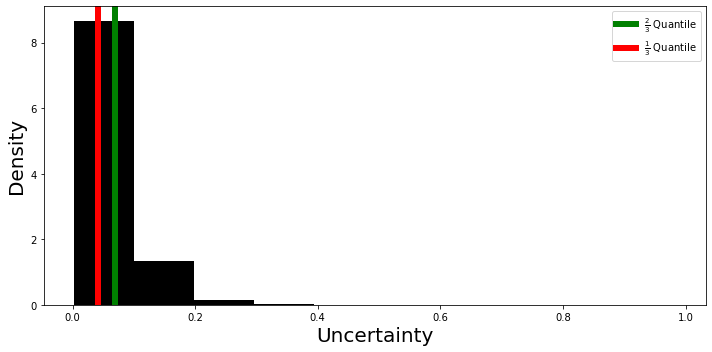

In [3]:
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/baseline')}
model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/baseline', min(files, key=files.get)))

for i in range(4):
    model_ = MF(data.n_user, data.n_item, embedding_dim=10, lr=model.lr, weight_decay=model.weight_decay)
    train(model_, data, path='checkpoints/ensemble', name=f'{i}')
    
models = [model]
for file in os.listdir('checkpoints/ensemble'):
    models.append(MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/ensemble', file))
ensemble = Ensemble(models)
test(ensemble, data, name='Ensemble', max_k=10)

# Resample

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

{'ratings': {'avg_unc': 0.13703935771388104,
  'std_unc': 0.0814443323292431,
  'RPI': 0.6048284617200482,
  'Classification': 0.5678172997653941,
  'Quantile RMSE': array([0.79388888, 0.80266228, 0.81044886, 0.82359573, 0.82827288,
         0.83839924, 0.84630079, 0.85776562, 0.85926344, 0.86986652,
         0.85930802, 0.88462706, 0.90258526, 0.92155497, 0.92880926,
         0.94931744, 0.9678014 , 0.98576561, 1.04082357, 1.18337713])},
 'uncertainty': {'Uncertainty_TopK': array([0.18370233, 0.171944  , 0.16430441, 0.16209323, 0.15895121,
         0.15506697, 0.1540648 , 0.15146904, 0.15036505, 0.14962897,
         0.14695449, 0.14733288, 0.14784226, 0.14416651, 0.14412049,
         0.14419263, 0.14334014, 0.14262514, 0.14290106, 0.14033682,
         0.14069513, 0.14084004, 0.14023198, 0.14024333, 0.13862896,
         0.13748762, 0.13779283, 0.1364636 , 0.13662714, 0.13759757,
         0.13717498, 0.13788173, 0.13530605, 0.13727833, 0.13620233,
         0.13354758, 0.13491977, 0.1345

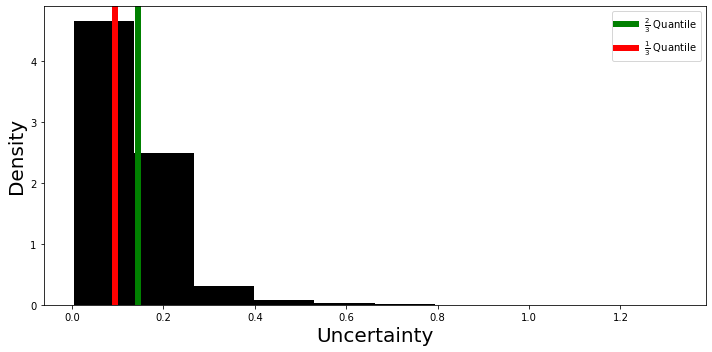

In [9]:
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/baseline')}
model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/baseline', min(files, key=files.get)))

og = deepcopy(data.train)
for i in range(5):
    data.train = og[np.random.choice(len(og), int(0.8*len(og)), replace=False), :]
    model = MF(data.n_user, data.n_item, embedding_dim=10, lr=model.lr, weight_decay=model.weight_decay)
    train(model, data, path='checkpoints/resample', name=f'{i}')
data.train = og

# Resample
models = []
for file in os.listdir('checkpoints/resample'):
    models.append(MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/resample', file))
resample = Resample(model, models)
test(resample, data, name='Resample', max_k=10, use_baseline=True)

# Zhu et. al

  0%|          | 0/6040 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

{'ratings': {'avg_unc': 0.67984885,
  'std_unc': 0.1735897,
  'RPI': 0.7084843967449974,
  'Classification': 0.6217572395925106,
  'Quantile RMSE': array([0.77521813, 0.69903585, 0.7295735 , 0.73937215, 0.76140583,
         0.77540339, 0.79668736, 0.80414287, 0.82513567, 0.84053621,
         0.86705283, 0.87735804, 0.88902778, 0.90359247, 0.94104155,
         0.96921103, 0.99259491, 1.03548933, 1.08549661, 1.24552994])},
 'uncertainty': {'Uncertainty_TopK': array([0.62771972, 0.62174447, 0.62062596, 0.62230459, 0.61762742,
         0.61766126, 0.61756443, 0.61723201, 0.61460368, 0.61622721,
         0.61292026, 0.61365395, 0.61234181, 0.61290613, 0.61192884,
         0.61227313, 0.6119736 , 0.61225717, 0.61485023, 0.61313209,
         0.6140045 , 0.61181501, 0.6132633 , 0.61226753, 0.61339873,
         0.61323143, 0.61237305, 0.6114326 , 0.61331116, 0.61345877,
         0.6115068 , 0.61253964, 0.61393108, 0.61289528, 0.61497977,
         0.61400296, 0.6139866 , 0.61236614, 0.61480713, 

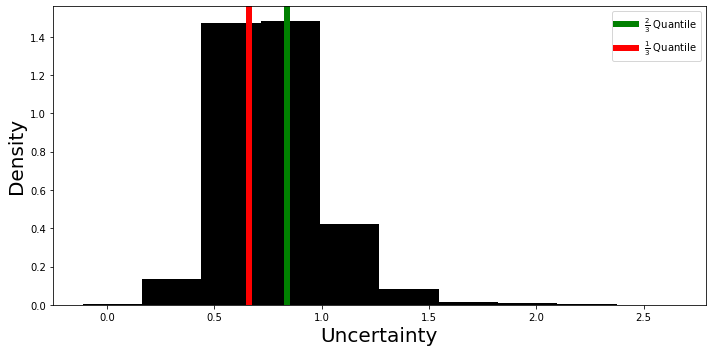

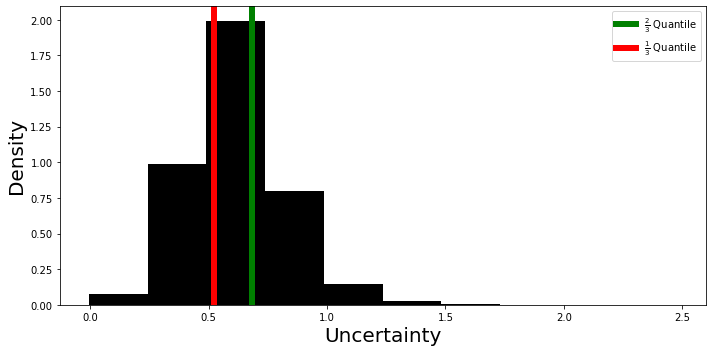

In [2]:
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/baseline')}
model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/baseline', min(files, key=files.get)))
errors = np.empty(len(data.train))
og = deepcopy(data.train)
og_val = deepcopy(data.val)
for i, (train_idx, test_idx) in enumerate(KFold(n_splits=2, shuffle=True).split(data.train)):
    test_rat = og[test_idx]
    data.train = og[train_idx]
    model_ = MF(data.n_user, data.n_item, embedding_dim=10, lr=0.0002, weight_decay=model.weight_decay)
    train(model_, data, path='checkpoints/cv', name=f'cv{i}')
    errors[test_idx] = np.abs(model_.predict(torch.tensor(test_rat[:, 0]).long(), torch.tensor(test_rat[:, 1]).long()) - test_rat[:, 2])
data.train = deepcopy(og)
data.train[:, 2] = errors
data.val[:, 2] = np.abs(model.predict(torch.tensor(data.val[:, 0]).long(), torch.tensor(data.val[:, 1]).long()) - data.val[:, 2])

# DoubleMF
model_ = MF(data.n_user, data.n_item, embedding_dim=10, lr=0.0002, weight_decay=model.weight_decay)
train(model_, data, path='checkpoints/cv', name=f'MF')

# Bias
model_ = Bias(data.n_user, data.n_item, lr=0.0002)
train(model_, data, path='checkpoints/cv', name=f'Bias')

#Fix
data.train = og
data.val = og_val

# Zhu
for file in os.listdir('checkpoints/cv'):
    if 'Bias' in file:
        bias = Bias(data.n_user, data.n_item, lr=0)
        bias = bias.load_from_checkpoint(os.path.join('checkpoints/cv', file))
    elif 'MF' in file:
        mf = MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
        mf = mf.load_from_checkpoint(os.path.join('checkpoints/cv', file))
bias_cv = UncertainWrapper(model, bias)
test(bias_cv, data, name='CV-Bias', max_k=10, use_baseline=True)
mf_cv = UncertainWrapper(model, mf)
test(mf_cv, data, name='CV-PMF', max_k=10, use_baseline=True)

# CPMF

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
2 | user_gammas     | Embedding | 6.0 K 
3 | item_gammas     | Embedding | 3.4 K 
4 | var_activation  | Softplus  | 0     
----------------------------------------------
104 K     Trainable params
0         Non-trainable params
104 K     Total params
0.416     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
2 | user_gammas     | Embedding | 6.0 K 
3 | item_gammas     | Embedding | 3.4 K 
4 | var_activation  | Softplus  | 0     
----------------------------------------------
104 K     Trainable params
0         Non-trainable params
104 K     Total params
0.416     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

{'ratings': {'RMSE': 0.8939031146988512,
  'avg_unc': 1.0140293,
  'std_unc': 0.28156948,
  'RPI': 0.36752776398773906,
  'Classification': 0.5621875394646325,
  'Quantile RMSE': array([0.8626773 , 0.81747906, 0.8119319 , 0.79704921, 0.79823042,
         0.80975299, 0.84252151, 0.84960037, 0.8433743 , 0.8624967 ,
         0.88193245, 0.87526688, 0.89152542, 0.90391094, 0.9137814 ,
         0.93033113, 0.9488176 , 0.9852472 , 1.01170973, 1.15881889])},
 'accuracy': {'Precision': array([0.07847682, 0.06978477, 0.06644592, 0.06423841, 0.06231788,
         0.06020971, 0.05823084, 0.05651904, 0.0553532 , 0.05395695]),
  'Recall': array([0.00536091, 0.00962171, 0.01345228, 0.01693214, 0.0202527 ,
         0.02355281, 0.0267259 , 0.02955965, 0.03243355, 0.03517105]),
  'NDCG': array([0.07847682, 0.15818479, 0.2233121 , 0.27867209, 0.32963931,
         0.37242517, 0.41076844, 0.44628373, 0.47567336, 0.50039581]),
  'Diversity': array([0.3522884 , 0.35960722, 0.36424457, 0.3678954 , 0.37090057,

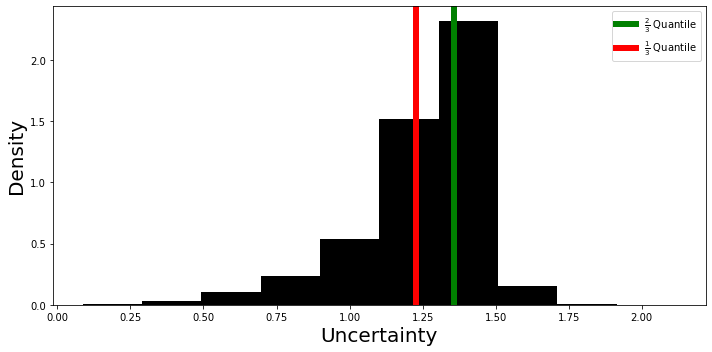

In [4]:
for wd in [0.01, 0.001]:
    for lr in [0.00001]:
        model = CPMF(data.n_user, data.n_item, embedding_dim=10, lr=0.0002, weight_decay=wd, lr_var=lr)
        train(model, data, path='checkpoints/cpmf', name=f'wd={wd}-lr={lr}')

files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/cpmf')}
model = CPMF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/cpmf', min(files, key=files.get)))
test(model, data, name='CPMF', max_k=10)

# OrdRec

  0%|          | 0/6040 [00:00<?, ?it/s]

{'ratings': {'RMSE': 0.8871492142669261,
  'avg_unc': 0.8594408754766613,
  'std_unc': 0.1979909408693766,
  'RPI': 0.7699498692389615,
  'Classification': 0.6536076560814351,
  'Quantile RMSE': array([0.63774731, 0.68719525, 0.70189963, 0.72770769, 0.73952565,
         0.77536171, 0.79240987, 0.80904507, 0.84301722, 0.85255316,
         0.87199443, 0.8783046 , 0.9097151 , 0.91862801, 0.94174914,
         0.97456059, 1.00327328, 1.06150956, 1.10258243, 1.25790493])},
 'accuracy': {'Precision': array([0.10645695, 0.09793046, 0.0919426 , 0.08708609, 0.08380795,
         0.08032561, 0.07880795, 0.07651076, 0.07422737, 0.07192053]),
  'Recall': array([0.00682606, 0.01274311, 0.01827314, 0.0228924 , 0.02741687,
         0.03154478, 0.03576883, 0.03921294, 0.04277808, 0.04607215]),
  'NDCG': array([0.10645695, 0.20486482, 0.29042578, 0.35809399, 0.41321503,
         0.4610355 , 0.50378795, 0.54066451, 0.57681531, 0.60698433]),
  'Diversity': array([0.2663391 , 0.27741989, 0.28710423, 0.29456

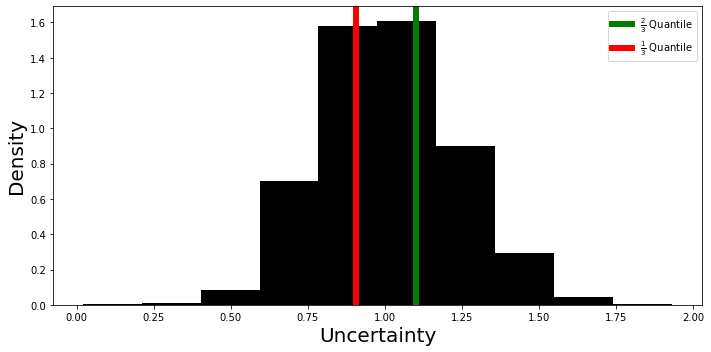

In [2]:
'''
data.to_ordinal()
for wd in [1, 0.01, 0.001]:
    for lr in [0.001, 0.0005, 0.0001]:
        model = OrdRec(data.n_user, data.n_item, data.score_labels, embedding_dim=10, lr=0.0002, weight_decay=wd, lr_step=lr)
        train(model, data, path='checkpoints/ordrec', name=f'wd={wd}-lr={lr}')
'''
score_labels = pd.factorize(data.train[:, 2], sort=True)[1]
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/ordrec')}
model = OrdRec(data.n_user, data.n_item, score_labels=score_labels, embedding_dim=10)
model = model.load_from_checkpoint(os.path.join('checkpoints/ordrec', min(files, key=files.get)))
test(model, data, name='OrdRec', max_k=10)

# BeMF

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 302 K 
1 | item_embeddings | Embedding | 170 K 
2 | sigmoid         | Sigmoid   | 0     
3 | softmax         | Softmax   | 0     
----------------------------------------------
472 K     Trainable params
0         Non-trainable params
472 K     Total params
1.891     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 302 K 
1 | item_embeddings | Embedding | 170 K 
2 | sigmoid         | Sigmoid   | 0     
3 | softmax         | Softmax   | 0     
----------------------------------------------
472 K     Trainable params
0         Non-trainable params
472 K     Total params
1.891     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 302 K 
1 | item_embeddings | Embedding | 170 K 
2 | sigmoid         | Sigmoid   | 0     
3 | softmax         | Softmax   | 0     
----------------------------------------------
472 K     Trainable params
0         Non-trainable params
472 K     Total params
1.891     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 302 K 
1 | item_embeddings | Embedding | 170 K 
2 | sigmoid         | Sigmoid   | 0     
3 | softmax         | Softmax   | 0     
----------------------------------------------
472 K     Trainable params
0         Non-trainable params
472 K     Total params
1.891     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddi

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 302 K 
1 | item_embeddings | Embedding | 170 K 
2 | sigmoid         | Sigmoid   | 0     
3 | softmax         | Softmax   | 0     
----------------------------------------------
472 K     Trainable params
0         Non-trainable params
472 K     Total params
1.891     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 302 K 
1 | item_embeddings | Embedding | 170 K 
2 | sigmoid         | Sigmoid   | 0     
3 | softmax         | Softmax   | 0     
----------------------------------------------
472 K     Trainable params
0         Non-trainable params
472 K     Total params
1.891     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 302 K 
1 | item_embeddings | Embedding | 170 K 
2 | sigmoid         | Sigmoid   | 0     
3 | softmax         | Softmax   | 0     
----------------------------------------------
472 K     Trainable params
0         Non-trainable params
472 K     Total params
1.891     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 302 K 
1 | item_embeddings | Embedding | 170 K 
2 | sigmoid         | Sigmoid   | 0     
3 | softmax         | Softmax   | 0     
----------------------------------------------
472 K     Trainable params
0         Non-trainable params
472 K     Total params
1.891     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

{'ratings': {'RMSE': 1.0913678140005076,
  'avg_unc': 0.6856061,
  'std_unc': 0.037908465,
  'RPI': 0.4523346173860886,
  'Classification': 0.6004284128297723,
  'Quantile RMSE': array([0.90429997, 0.99400797, 0.99771915, 1.02539643, 1.01102669,
         1.0065098 , 1.00368865, 0.95699953, 1.00161862, 1.02237794,
         1.06011111, 1.0671083 , 1.10610625, 1.11075445, 1.13077643,
         1.15570853, 1.16147662, 1.20063768, 1.29725385, 1.46772349])},
 'accuracy': {'Precision': array([0.03741722, 0.02640728, 0.02328918, 0.02226821, 0.02086093,
         0.02003311, 0.01944182, 0.0192053 , 0.01848786, 0.01819536]),
  'Recall': array([0.00233363, 0.00301501, 0.0038912 , 0.00486223, 0.00575279,
         0.00657705, 0.00729253, 0.00816884, 0.0088073 , 0.00963329]),
  'NDCG': array([0.03741722, 0.07234054, 0.10472145, 0.13316066, 0.15636467,
         0.17900312, 0.19856795, 0.21557291, 0.23344825, 0.25017681]),
  'Diversity': array([0.40527459, 0.41337265, 0.41653285, 0.41843129, 0.42003126,

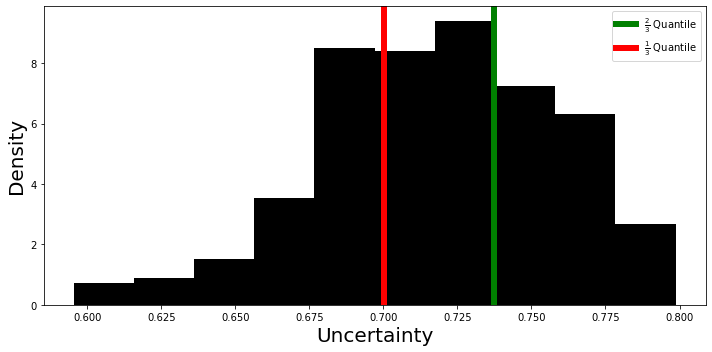

In [3]:
data.to_ordinal()
for wd in [1, 0.1, 0.01]:
    for lr in [0.05, 0.01, 0.005]:
        model = BeMF(data.n_user, data.n_item, data.score_labels, embedding_dim=50, lr=lr, weight_decay=wd)
        train(model, data, path='checkpoints/bemf', name=f'wd={wd}-lr={lr}')
        
score_labels = pd.factorize(data.train[:, 2], sort=True)[1]
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/bemf')}
model = BeMF(data.n_user, data.n_item, score_labels=score_labels, embedding_dim=10)
model = model.load_from_checkpoint(os.path.join('checkpoints/bemf', min(files, key=files.get)))
test(model, data, name='BeMF', max_k=10)

# Results

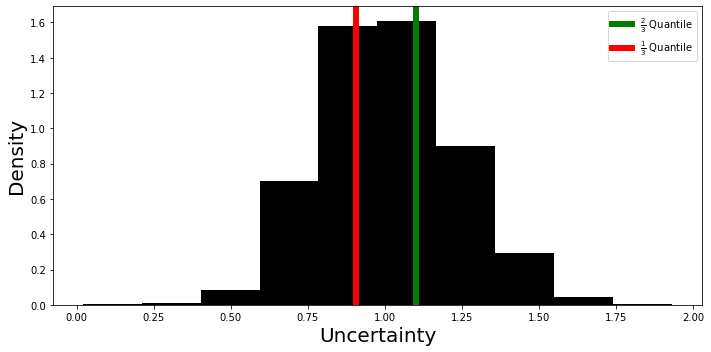

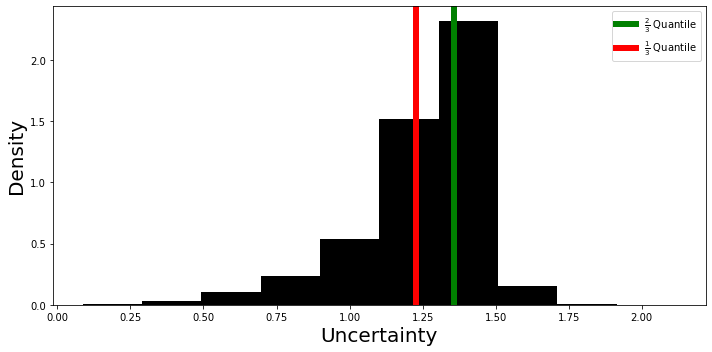

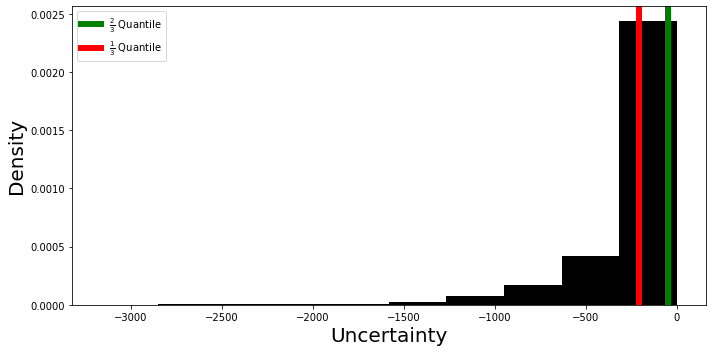

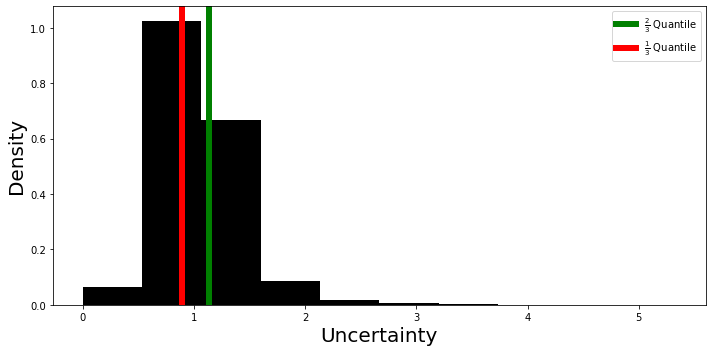

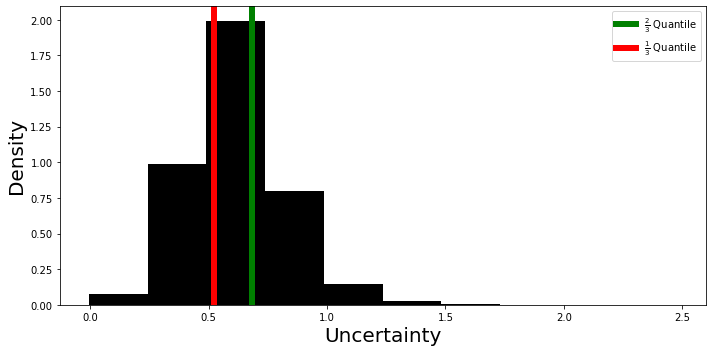

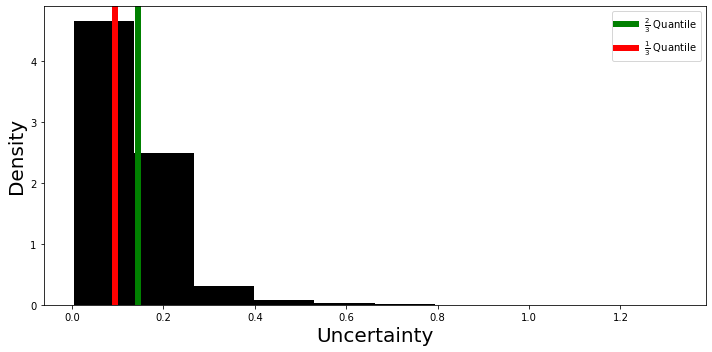

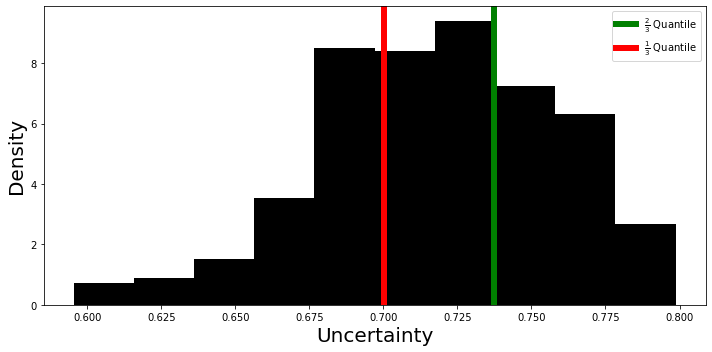

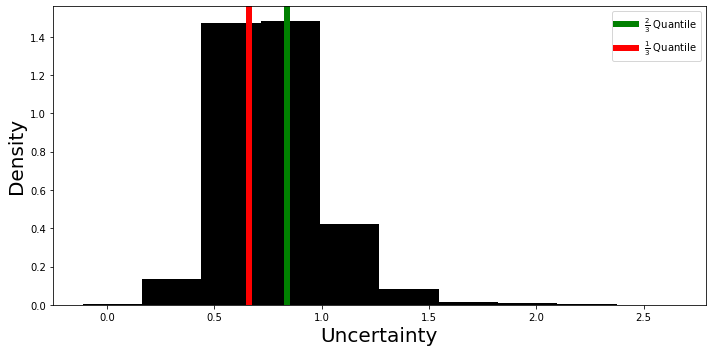

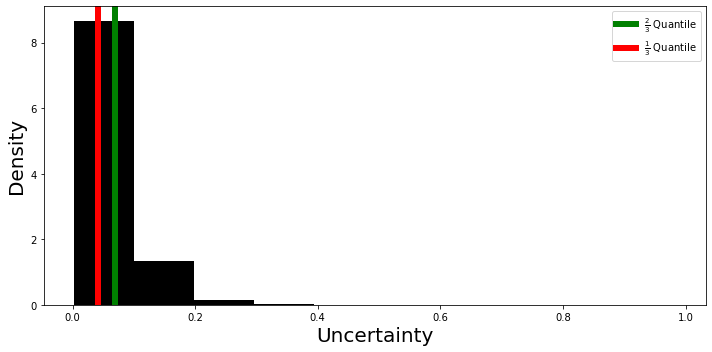

In [70]:
# Load
results = {}
for key in os.listdir('results'):
    results[key.replace('.pkl', '').replace('_', ' ')] = pickle.load(open(os.path.join('results', key), 'rb'))
colors = [c for c in list(TABLEAU_COLORS)] + ['k']
colors = {k:c for k, c in zip(results, colors)}

                   RMSE       RPI  Classification
OrdRec         0.887149  0.769950        0.653608
CPMF           0.893903  0.367528        0.562188
Item support        NaN  0.078239        0.523490
Baseline       0.887688       NaN             NaN
Item variance       NaN  0.390879        0.572001
CV-PMF              NaN  0.708484        0.621757
Resample            NaN  0.604828        0.567817
BeMF           1.091368  0.452335        0.600428
CV-Bias             NaN  0.794383        0.635292
Ensemble       0.881004  0.333511        0.541498


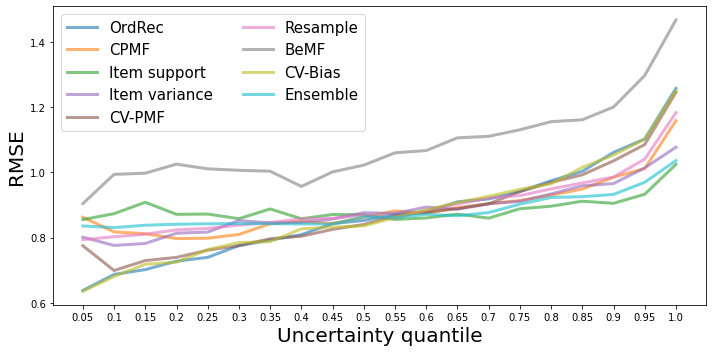

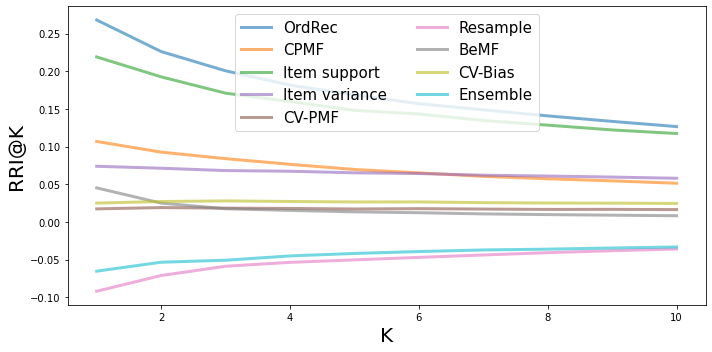

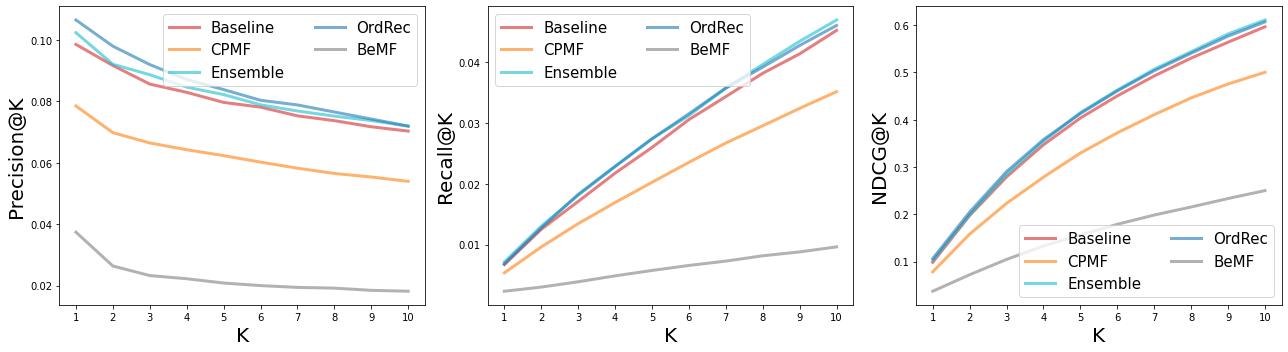

In [71]:
# Rating prediction evaluation
ratings = pd.DataFrame([results[key]['ratings'] for key in results], index=results.keys())[['RMSE', 'RPI', 'Classification']]
print(ratings)

# Uncertainty-RMSE curve
keys = [key for key in results if key != 'Baseline']
f, ax = plt.subplots(figsize=(10, 5))
for key in keys:
    ax.plot(np.arange(1, 21), results[key]['ratings']['Quantile RMSE'],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax.set_xticks(np.arange(1, 21))
ax.set_xticklabels([round(elem, 2) for elem in np.linspace(start=0.05, stop=1, num=20).tolist()])
ax.set_xlabel('Uncertainty quantile', fontsize=20)
ax.set_ylabel('RMSE', fontsize=20)
ax.legend(ncol=2, fontsize=15)
f.tight_layout()
f.savefig('plots/RMSE-uncertainty.pdf')

# RRI
f, ax = plt.subplots(figsize=(10, 5))
for key in keys:
    ax.plot(np.arange(1, 11), results[key]['uncertainty']['RRI'],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax.set_xlabel('K', fontsize=20)
ax.set_ylabel('RRI@K', fontsize=20)
ax.legend(ncol=2, fontsize=15)
f.tight_layout()
f.savefig('plots/RRI.pdf')

# Top-K accuracy metrics
keys = ['Baseline', 'CPMF', 'Ensemble', 'OrdRec', 'BeMF']
f, ax = plt.subplots(ncols=3, figsize=(18, 5), sharex=True)
for key in keys:
    ax[0].plot(np.arange(1, 11), results[key]['accuracy']['Precision'],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1].plot(np.arange(1, 11), results[key]['accuracy']['Recall'],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[2].plot(np.arange(1, 11), results[key]['accuracy']['NDCG'],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('K', fontsize=20)
ax[0].set_ylabel('Precision@K', fontsize=20)
ax[0].legend(ncol=2, fontsize=15)
ax[1].set_xlabel('K', fontsize=20)
ax[1].set_ylabel('Recall@K', fontsize=20)
ax[1].legend(ncol=2, fontsize=15)
ax[2].set_xlabel('K', fontsize=20)
ax[2].set_ylabel('NDCG@K', fontsize=20)
ax[2].legend(ncol=2, fontsize=15)
f.tight_layout()
f.savefig('plots/accuracy.pdf')

In [82]:
def retrieve_metric(metric, key):
    try:
        out = results[key]['accuracy'][metric][-1]
    except:
        out = results['Baseline']['accuracy'][metric][-1]
    return [out] + [results[key]['cuts'][cut][metric][-1] for cut in ['2/3', '1/3']]

# Rating prediction evaluation
a = {metric: {key: retrieve_metric(metric, key) for key in results if key != 'Baseline'} for metric in ['Precision', 'Diversity', 'Expected surprise']}
for key in a:
    print(f'\n {key}:')
    print(pd.DataFrame(a[key], index=['No cut', '2/3 quantile cut',  '1/3 quantile cut']).T)


 Precision:
                 No cut  2/3 quantile cut  1/3 quantile cut
OrdRec         0.071921          0.071457          0.069702
CPMF           0.053957          0.061755          0.068675
Item support   0.070298          0.070364          0.073129
Item variance  0.070298          0.068841          0.064338
CV-PMF         0.070298          0.055795          0.030613
Resample       0.070298          0.050149          0.037417
BeMF           0.018195          0.020281          0.022732
CV-Bias        0.070298          0.064967          0.048444
Ensemble       0.071904          0.039387          0.025381

 Diversity:
                 No cut  2/3 quantile cut  1/3 quantile cut
OrdRec         0.318152          0.319799          0.322833
CPMF           0.379289          0.332471          0.321314
Item support   0.326994          0.326921          0.318816
Item variance  0.326994          0.326594          0.328964
CV-PMF         0.326994          0.352173          0.404792
Resample      